In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Steps
#1. Assign K CLusters
#2. Compute the CENTROID of every Clusters
#3. Keep doing it until cluster Assignments do not change

In [3]:
SIL_CLUSTER_SCORES = []
CLUSTER_DATA = []

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/USECASE_1.xlsx', sheet_name='Sheet1')
df

,AssessmentDate,AssessmentTopics,Count,Status,Description
0,2024-05-28,"Benefits of Dermatology, Benefits of Vermosics...",43.0,Completed,With the same humor and humanity he exuded in ...
1,2024-05-29,"Benefits of Dermatology, Benefits of Vermosics...",35.0,Completed,Fumes from indoor cooking fires kill more than...
2,2024-05-30,"Benefits of Dermatology, Benefits of Vermosics...",22.0,Completed,Ashraf Ghani's passionate and powerful 10-minu...
3,2024-05-31,"Benefits of Dermatology, Benefits of Vermosics...",31.0,Completed,"In this passionate talk, legendary spacecraft ..."
4,2024-06-01,"Benefits of Dermatology, Benefits of Vermosics...",19.0,Completed,American designer Chris Bangle explains his ph...
...,...,...,...,...,...
2470,NaT,NaN,NaN,NaN,There's a creepy transformation taking over ou...
2471,NaT,NaN,NaN,NaN,Attention isn't just about what we focus on i...
2472,NaT,NaN,NaN,NaN,"The hard choices what we most fear doing, ask..."
2473,NaT,NaN,NaN,NaN,"A few days before she turned 61, writer Anne L..."


In [6]:
df =  df[['Description']]

In [7]:
df

,Description
0,With the same humor and humanity he exuded in ...
1,Fumes from indoor cooking fires kill more than...
2,Ashraf Ghani's passionate and powerful 10-minu...
3,"In this passionate talk, legendary spacecraft ..."
4,American designer Chris Bangle explains his ph...
...,...
2470,There's a creepy transformation taking over ou...
2471,Attention isn't just about what we focus on i...
2472,"The hard choices what we most fear doing, ask..."
2473,"A few days before she turned 61, writer Anne L..."


In [8]:
df.head(10)

,Description
0,With the same humor and humanity he exuded in ...
1,Fumes from indoor cooking fires kill more than...
2,Ashraf Ghani's passionate and powerful 10-minu...
3,"In this passionate talk, legendary spacecraft ..."
4,American designer Chris Bangle explains his ph...
5,Genomics pioneer Craig Venter takes a break fr...
6,New York Times columnist David Pogue takes aim...
7,In this emotionally charged conversation with ...
8,Inventor Dean Kamen lays out his argument for ...
9,Forget the latest disease in the news: Cardiov...


In [9]:
df.describe()

,Description
count,2475
unique,2475
top,With the same humor and humanity he exuded in ...
freq,1


In [ ]:
categories = [
    "Category1",
    "Category2",
    "Category3",
    "Category4",
]
categories

['Category1', 'Category2', 'Category3', 'Category4']

In [10]:
vectoriser =  TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [11]:
from time import time
t0=  time()
t0

1721629506.644971

In [12]:
tfidfvec =  vectoriser.fit_transform(df['Description'])

In [13]:
tfidfvec.shape
# NO OF SAMPELS = tfidfvec.shape[0]
# NO OF FEATURES =  tfidfvec.shape[1]

(2475, 2831)

In [14]:
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 7.905 s


In [15]:
print(f"n_samples: {tfidfvec.shape[0]}, n_features: {tfidfvec.shape[1]}")

n_samples: 2475, n_features: 2831


In [16]:
tfidfvec.data

array([0.3155647 , 0.19051184, 0.26876662, ..., 0.18113092, 0.21481414,
       0.1626929 ])

In [17]:
tfidfvec.nnz

47649

In [18]:
np.prod(tfidfvec.shape)

7006725

In [ ]:
#tfidfvec.shape = 2475 * 2831

In [19]:
#find non zero enteries in the matrix
tfidfvec.nnz/np.prod(tfidfvec.shape)
# 0.6% of  the enteries are NON ZERO in the MATRIX

0.0068004666944970725

Text(0, 0.5, 'Inertia')

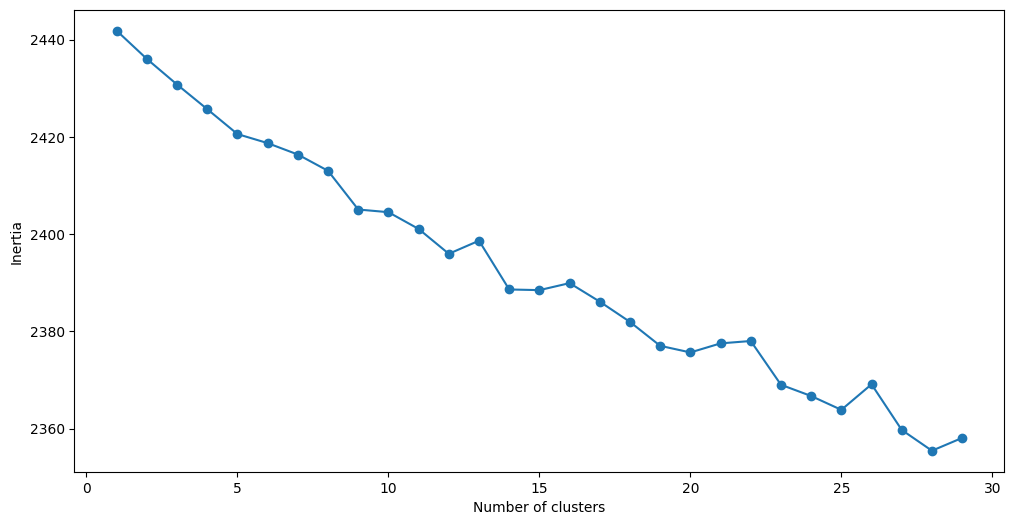

In [20]:
# ELBOW METHOD
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,30):
    kmeans = KMeans(n_clusters=cluster, max_iter=500, n_init=1,
                    random_state=cluster, init='k-means++', algorithm='lloyd')
    #ALGO = {"lloyd", "elkan", "auto", "full"},
    kmeans.fit(tfidfvec)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [21]:
for seed in range(25):
    kmeans = KMeans(
        n_clusters=25,
        max_iter=300,
        n_init=10,
        random_state=seed,
    ).fit(tfidfvec)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

    silscore = metrics.silhouette_score(tfidfvec, kmeans.labels_, sample_size=tfidfvec.shape[0])
    print(f"{cluster_ids[seed]} : Number of elements assigned to each cluster : {cluster_sizes}")
    print(f"SIL Score :  {silscore}")
print()

0 : Number of elements assigned to each cluster : [ 76  98  71  57 180  78  33  29  91  69  61  72 220  83  82  50 197 148
 136  83  70 139  89 151 112]
SIL Score :  0.006069724242123066
1 : Number of elements assigned to each cluster : [ 66 109 112 121  90 245  59  54 126  59  87  90 175  67  57  33 112 169
 155 104  80  63  40 145  57]
SIL Score :  0.00574378002819907
2 : Number of elements assigned to each cluster : [177  87  73 131  62 105 100  61  71  66  94 119  84 284  96  69 123 104
  88  59  79 134  61  57  91]
SIL Score :  0.005565450116937162
3 : Number of elements assigned to each cluster : [ 64  95  58  74  65  97 123 108  56  92 161 107  73 314  74  81  59  78
 243  43  53 101  89  78  89]
SIL Score :  0.0054965650960898714
4 : Number of elements assigned to each cluster : [ 99 195  47  60  69 101 145  81  75 204 130  65  79  54  42  95  37 174
  72  54  62 100 317  51  67]
SIL Score :  0.005340417083668117
5 : Number of elements assigned to each cluster : [308 227  76  8

In [22]:
LSA =  make_pipeline(TruncatedSVD(n_components=1000), Normalizer(copy=False))
t0 = time()
X_LSA = LSA.fit_transform(tfidfvec)
explained_variance = LSA[0].explained_variance_ratio_.sum()

In [23]:
print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 7.219 s
Explained variance of the SVD step: 83.3%


In [24]:
X_LSA

array([[ 0.11141319, -0.05937962,  0.07512107, ...,  0.01036995,
         0.00223343, -0.00182462],
       [ 0.10680207,  0.00235357,  0.04068691, ...,  0.03120486,
         0.01206936,  0.01798509],
       [ 0.14141443,  0.05084451, -0.04940802, ..., -0.01882926,
        -0.00025476,  0.00798812],
       ...,
       [ 0.11813894, -0.02277473,  0.03747255, ..., -0.02962858,
        -0.00931519, -0.00573864],
       [ 0.13472019,  0.12234101,  0.00402231, ..., -0.0171987 ,
        -0.00617372,  0.02251109],
       [ 0.11853711, -0.04634765, -0.09751579, ..., -0.01700509,
         0.0086328 ,  0.01935451]])

In [25]:
X_LSA.shape

(2475, 1000)

In [26]:
kmeans.labels_

array([21, 18, 13, ..., 19,  4, 20], dtype=int32)

In [27]:
for seed in range(25):
    innerPayload = {}
    kmeans = KMeans(
        n_clusters=25,
        max_iter=300,
        n_init=5,
        random_state=seed,
    ).fit(X_LSA)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

    silscore = metrics.silhouette_score(X_LSA, kmeans.labels_, sample_size=X_LSA.shape[0])
    print(f"{cluster_ids[seed]} : Number of elements assigned to each cluster : {cluster_sizes}")
    print(f"SIL Score :  {silscore}")
    innerPayload['SILScore'] = silscore * 100
    SIL_CLUSTER_SCORES.append(innerPayload)
print()

0 : Number of elements assigned to each cluster : [ 78 423 173 121 100  59  69  38  88 204  46 105  62  76  61  56 112 146
  53  67  32  72  57 120  57]
SIL Score :  0.008197767504866359
1 : Number of elements assigned to each cluster : [172 285  43  53 144 121  86 116 167  43 139  77 106  59  66  79  86 100
 134  48 103  56  68  64  60]
SIL Score :  0.00802870786365258
2 : Number of elements assigned to each cluster : [ 83  55 104  75 279  79 107 236  80 104  88  65 109  58  43 116 104  62
  97 138  37  86 137  60  73]
SIL Score :  0.008055479015708378
3 : Number of elements assigned to each cluster : [101 154 115  81 107 129  51 105  86 180  63 101  77 183 138  66 172  50
  85  54 107 106  37  38  89]
SIL Score :  0.008001095919732748
4 : Number of elements assigned to each cluster : [ 87  73  87  65  79  59  88 298 130  89  59 102  46  47  80 281  63  88
  54  90  67  81 101 100 161]
SIL Score :  0.007542329780607963
5 : Number of elements assigned to each cluster : [105  40 162 133

In [28]:
SIL_CLUSTER_SCORES

[{'SILScore': 0.8197767504866359},
 {'SILScore': 0.802870786365258},
 {'SILScore': 0.8055479015708378},
 {'SILScore': 0.8001095919732748},
 {'SILScore': 0.7542329780607964},
 {'SILScore': 0.7691539117984603},
 {'SILScore': 0.8548429931936237},
 {'SILScore': 0.8216624823006893},
 {'SILScore': 0.7648449221325937},
 {'SILScore': 0.7850703486115527},
 {'SILScore': 0.7993808364967261},
 {'SILScore': 0.8445376392280027},
 {'SILScore': 0.8172234145073521},
 {'SILScore': 0.8173982327522175},
 {'SILScore': 0.7794656981067978},
 {'SILScore': 0.8006095719295283},
 {'SILScore': 0.8319739655979935},
 {'SILScore': 0.8187978745207868},
 {'SILScore': 0.7105580971895366},
 {'SILScore': 0.8276826131246173},
 {'SILScore': 0.9017650110451251},
 {'SILScore': 0.8050390964739347},
 {'SILScore': 0.752913125097428},
 {'SILScore': 0.8448337499030428},
 {'SILScore': 0.7946207381820105}]

In [ ]:
#BEST SCORE AFTER LSA APPLICATION ON THE VECTORISED DATA
# NO OF CLUSTRERS : 25 : Number of elements assigned to each cluster : [ 77 147 149  62 38 111 72 123 139 61 29 73 37 61 82 87 115 72 49 517 111 49 70 122 22 ]
# SIL Score :  0.008748524433901754

In [29]:
vectoriser.get_feature_names_out()

array(['000', '10', '100', ..., 'yves', 'zero', 'zones'], dtype=object)

In [30]:
original_space_centroids = LSA[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectoriser.get_feature_names_out()



In [31]:
for i in terms:
  print(f" value : {i}, ", end='')

 value : 000,  value : 10,  value : 100,  value : 11,  value : 12,  value : 13,  value : 14,  value : 15,  value : 16,  value : 17,  value : 18,  value : 19,  value : 1970s,  value : 1998,  value : 20,  value : 200,  value : 2003,  value : 2005,  value : 2006,  value : 2007,  value : 2008,  value : 2009,  value : 2010,  value : 2011,  value : 2012,  value : 2013,  value : 2014,  value : 2015,  value : 2016,  value : 22,  value : 24,  value : 25,  value : 30,  value : 3d,  value : 40,  value : 50,  value : 500,  value : 70,  value : 80,  value : 90,  value : abandoned,  value : ability,  value : able,  value : aboard,  value : abundant,  value : abuse,  value : accepting,  value : access,  value : accessible,  value : accident,  value : accompanied,  value : according,  value : account,  value : achieve,  value : act,  value : action,  value : actions,  value : activism,  value : activist,  value : activists,  value : activity,  value : actor,  value : acts,  value : actually,  value : 

In [32]:
terms.shape

(2831,)

In [33]:
term_frequencies = kmeans.cluster_centers_[24]

In [34]:
term_frequencies.shape

(1000,)

In [35]:
for i in range(25):
    innerPayload = {}
    innerList = []
    print(f"Cluster {i} :: ")
    print(order_centroids[i])
    #print(f"Centroids Complete DATA : {order_centroids[0:len(order_centroids)]}")
    for ind in order_centroids[i, :len(order_centroids)]:
        #print(f"{terms[ind]} ", end="")
        print(f"{terms[ind]} ", end="")
        innerList.append(terms[ind])
    #print(innerList)
    innerPayload['Cluster'] = innerList
    #print(innerPayload)
    CLUSTER_DATA.append(innerPayload)
    print("---------------------------------------")

Cluster 0 :: 
[1525 1688 2188 ... 2469 2018 2089]
make need says better talk world time future human shows life decisions new like people choices know city help just shares suggests urban good actually ---------------------------------------
Cluster 1 :: 
[2501  949 2482 ... 2043  514 1075]
ted fellow talk says shows new shares artist just world short want people technology work life senior calls make anderson chris years simple actually disease ---------------------------------------
Cluster 2 :: 
[1502 1475  725 ...  818 2742  390]
look like does earth new just humans talk place life ll shows says future world using brain human work know space team history mars planet ---------------------------------------
Cluster 3 :: 
[2408 2522 1470 ... 1123  688 1304]
story tells life talk young moving world tale powerful years people family lives stories living personal remarkable girls war new funny shocking father just imagine ---------------------------------------
Cluster 4 :: 
[1446 1396 2

In [36]:
CLUSTER_DATA

[{'Cluster': ['make',
   'need',
   'says',
   'better',
   'talk',
   'world',
   'time',
   'future',
   'human',
   'shows',
   'life',
   'decisions',
   'new',
   'like',
   'people',
   'choices',
   'know',
   'city',
   'help',
   'just',
   'shares',
   'suggests',
   'urban',
   'good',
   'actually']},
 {'Cluster': ['ted',
   'fellow',
   'talk',
   'says',
   'shows',
   'new',
   'shares',
   'artist',
   'just',
   'world',
   'short',
   'want',
   'people',
   'technology',
   'work',
   'life',
   'senior',
   'calls',
   'make',
   'anderson',
   'chris',
   'years',
   'simple',
   'actually',
   'disease']},
 {'Cluster': ['look',
   'like',
   'does',
   'earth',
   'new',
   'just',
   'humans',
   'talk',
   'place',
   'life',
   'll',
   'shows',
   'says',
   'future',
   'world',
   'using',
   'brain',
   'human',
   'work',
   'know',
   'space',
   'team',
   'history',
   'mars',
   'planet']},
 {'Cluster': ['story',
   'tells',
   'life',
   'talk',
   'y

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import io
import base64
from PIL import Image

In [38]:
def frequencies_dict(cluster_index):
    #print(cluster_index)
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    #print(term_frequencies.shape)
    #print(term_frequencies)
    # print("~~~~~~~~~~~~~~~~~")
    sorted_terms = order_centroids[cluster_index]
    print(terms.shape)
    #print(terms)
    #print("~~~~~~~~~~~~~~~~~")
    counts = Counter(terms)
    #print(counts)
    #print(type(counts))


    # print(terms.shape)
    #frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return counts

In [61]:
image = ''

In [77]:
def makeImage(frequencies):
    wc = WordCloud(background_color="white", max_words=2831)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)
    # show
    plt.figure(figsize=(20,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")


    # my_stringIObytes = io.BytesIO()
    # plt.savefig(my_stringIObytes, format='jpg')
    # my_stringIObytes.seek(0)
    # my_base64_jpgData = base64.b64encode(my_stringIObytes.read()).decode()
    # #####print(my_base64_jpgData)


    figfile = io.BytesIO()
    plt.savefig(figfile, format='png')
    figfile.seek(0)  # rewind to beginning of file
    import base64
    #figdata_png = base64.b64encode(figfile.read())
    figdata_png = base64.b64encode(figfile.getvalue())
    figdata_png = figdata_png.decode("utf-8")
    print(figdata_png)
    plt.show()


(2831,)
iVBORw0KGgoAAAANSUhEUgAAB9AAAAJYCAYAAAA6431rAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz955ccV5rv+323CZe+HAogANpudvfYc4+uro7WlZb0h0taV2uOlqQzZ87MdE8bOoCw5avSh9173xcRmSiQAAiQoO3nwwUWCWRlRURGGsRvP8+jQggBIYQQQgghhBBCCCGEEEIIIYQQ4q+c/rE3QAghhBBCCCGEEEIIIYQQQgghhPgpkABdCCGEEEIIIYQQQgghhBBCCCGEQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAAXQghhBBCCCGEEEIIIYQQQgghhAAkQBdCCCGEEEIIIYQQQgghhBBCCCEACdCFEEIIIYQQQgghhBBCCCGEEEIIQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAAXQghhBBCCCGEEEIIIYQQQgghhAAkQBdCCCGEEEIIIYQQQgghhBBCCCEACdCFEEIIIYQQQgghhBBCCCGEEEIIQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAAXQghhBBCCCGEEEIIIYQQQgghhAAkQBdCCCGEEEIIIYQQQgghhBBCCCEACdCFEEIIIYQQQgghhBBCCCGEEEIIQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAAXQghhBBCCCGEEEIIIYQQQgghhAAkQBdCCCGEEEIIIYQQQgghhBBCCCEACdCFEEIIIYQQQgghhBBCCCGEEEIIQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAAXQghhBBCCCGEEEIIIYQQQgghhAAkQBdCCCGEEEIIIYQQQgghhBBCCCEACdCFEEIIIYQQQgghhBBCCCGEEEIIQAJ0IYQQQgghhBBCCCGEEEIIIYQQApAA

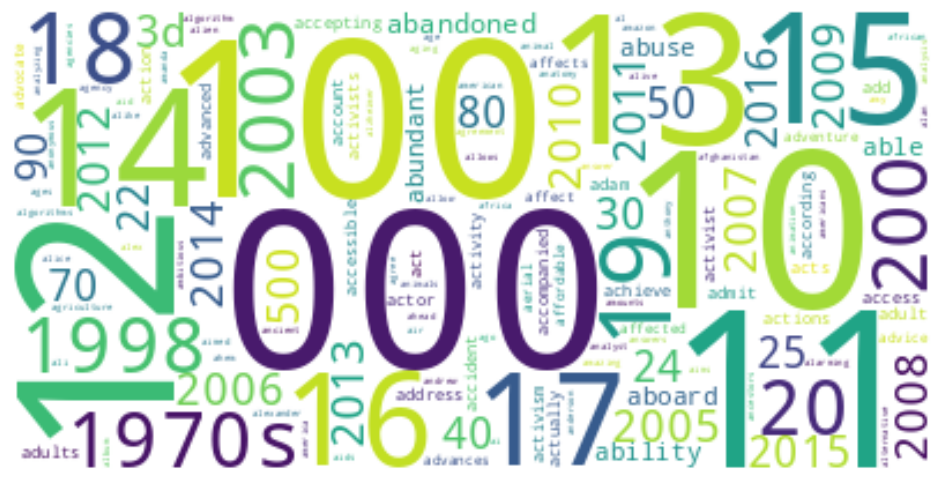

In [78]:
freq = frequencies_dict(0)
makeImage(freq)
print()

In [ ]:
# #RESULT 1
# Number of elements assigned to each cluster: [519 465 539 952]
# Number of elements assigned to each cluster: [1156  271  288  760]
# Number of elements assigned to each cluster: [528 964 637 346]
# Number of elements assigned to each cluster: [1081  476  634  284]
# Number of elements assigned to each cluster: [ 498  700 1047  230]

# True number of documents in each category according to the class labels: ['Category1', 'Category2', 'Category3', 'Category4']

# #RESULT 2





In [71]:
image

''

In [66]:
import matplotlib.image as mpimg

In [ ]:
iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAIyUlEQVR4nO3WMQEAIAzAMMC/5+ECjiYKenbPzCwAADLO7wAAAN4ygAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIuJnkHvKensmIAAAAASUVORK5CYII=

In [67]:
i = base64.b64decode(image)
i = io.BytesIO(i)
i = mpimg.imread(i, format='JPG')

plt.imshow(i, interpolation='nearest')
plt.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d7062048310>